In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

from sklearn.preprocessing import Imputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import MinMaxScaler, StandardScaler,scale
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn, optim
import torch.nn.init as init
import torch.utils.data as Data
import math


import matplotlib.pyplot as plt
import torch.multiprocessing as mp


In [2]:
mp.set_start_method('spawn')

## hyperparameters

In [3]:
batch_size = 128
use_gpu = True
y_scale = True
lr = 0.0015
weight_decay = 0.001

# Batch size and learning rate is hyperparameters in deep learning
# suggest batch_size is reduced, lr is also reduced which will reduce concussion

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
X = pd.read_csv('./dataset-0510/train.csv')
X_test = pd.read_csv('./dataset-0510/test.csv')


columns = X.columns


In [6]:
columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

## Imputer, Scaler, Feature selection

In [7]:
# step1. Imputation transformer for completing missing values.
step1 = ('Imputer', Imputer())
# step2. MinMaxScaler
step2 = ('MinMaxScaler', MinMaxScaler())
# step3. feature selection
#step3 = ('FeatureSelection', SelectFromModel(RandomForestRegressor()))
step3 = ('FeatureSelection', VarianceThreshold())

pipeline = Pipeline(steps=[step1, step2, step3])


/home/islab/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [8]:
y = X['total_price']
X = X.drop(columns=['building_id', 'total_price'], axis=1)
X_test = X_test.drop(columns=['building_id'], axis=1)


### X sacle

In [9]:
X = pipeline.fit_transform(X)
print(X.shape)

X_test = pipeline.transform(X_test)
print(X_test.shape)

(60000, 211)
(10000, 211)


In [10]:
#X = pd.DataFrame(X, columns=columns)

### y scale 

In [11]:
y_scaler = MinMaxScaler()
if y_scale:
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))



In [12]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=42) 

In [13]:
X_train = torch.from_numpy(X_train).float().to(device)
X_eval = torch.from_numpy(X_eval).float().to(device)

y_train = torch.from_numpy(y_train).float().to(device)
y_eval = torch.from_numpy(y_eval).float().to(device)

X_test = torch.from_numpy(X_test).float().to(device)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

torch.Size([42000, 211])
torch.Size([10000, 211])
torch.Size([42000, 1])


In [15]:
train_dataset = Data.TensorDataset(X_train, y_train)
train_loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

eval_dataset = Data.TensorDataset(X_eval, y_eval)
eval_loader = Data.DataLoader(
    dataset=eval_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

## building model

In [16]:
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # apply a uniform distribution to the weights and a bias=0
        m.weight.data.uniform_(0.0, 1.0)
        m.bias.data.fill_(0)

class DNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(211, 256)
        self.bn1 = nn.BatchNorm1d(num_features=256)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(num_features=512)
        
        self.fc3 = nn.Linear(512, 512)
        self.bn3 = nn.BatchNorm1d(num_features=512)
        
        self.fc4 = nn.Linear(512, 256)
        self.bn4 = nn.BatchNorm1d(num_features=256)
        
        self.fc5 = nn.Linear(256, 128)
        self.bn5 = nn.BatchNorm1d(num_features=128)
        
        self.fc6 = nn.Linear(128, 64)
        self.bn6 = nn.BatchNorm1d(num_features=64)
        
        self.fc7 = nn.Linear(64, 32)
        self.bn7 = nn.BatchNorm1d(num_features=32)
        
        self.fc8 = nn.Linear(32, 1)
        
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #x = x.unsqueeze(0)
        
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.bn3(self.fc3(x)))
        x = F.relu(self.bn4(self.fc4(x)))
        x = F.relu(self.bn5(self.fc5(x)))
        x = F.relu(self.bn6(self.fc6(x)))
        x = F.relu(self.bn7(self.fc7(x)))
        x = self.fc8(x)

        return x

In [17]:
model = DNN().to(device)
model.apply(weights_init_uniform)
criterion = nn.MSELoss()
optim = optim.Adam(model.parameters(), lr= lr)

In [18]:

def train_func(model, loader):
    model.train()
    train_loss = []
    for step, (batch_x, batch_y) in enumerate(loader):
        optim.zero_grad()
        pred = model(batch_x)
        loss = torch.sqrt(criterion(pred, batch_y))
        loss.backward()
        optim.step()

        train_loss.append(loss.item())
        
    print('training loss', np.array(train_loss).mean())
    return np.array(train_loss).mean()




def eval_func(model, loader):
    model.eval()
    eval_loss = []
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(loader):
            pred = model(batch_x)
            loss = torch.sqrt(criterion(pred, batch_y))
            
            eval_loss.append(loss.item())
        print('testing loss', np.array(eval_loss).mean())
    return np.array(eval_loss).mean()

def test_func(model, X):
    model.eval()
    with torch.no_grad():
        pred = model(X)
        
        pred = pred.cpu().numpy()
        if y_scale:
            pred = y_scaler.inverse_transform(pred)            
    return pred


def accuracy(model, pct_close=0.5):
    #pred, y_eval
    model.eval()
    with torch.no_grad():
        pred = model(X_eval)
        
    n_correct = torch.sum((torch.abs(pred - y_eval) < torch.abs(pct_close * y_eval)))
    result = (n_correct.item()/len(y_eval))  # scalar
    return result 

def plot(label, pred):
    plt.plot(label, label='actual')
    plt.plot(pred, label='pred')
    plt.legend(frameon=False)
    

In [19]:
train_losses = []
eval_losses = []
#accs = []
for t in range(10000):
    print('epochs', t)
    train_loss = train_func(model, train_loader)
    if (t+1) % 10 == 0:
        eval_loss = eval_func(model, eval_loader)
        #acc = accuracy(model)
        
        eval_losses.append(eval_loss)
        train_losses.append(train_loss)
        
        #accs.append(acc)
        #print('accuracy: ',acc)

epochs 0
training loss 1.8065910579914108
epochs 1
training loss 0.03416448657182937
epochs 2
training loss 0.030666240418788418
epochs 3
training loss 0.027859439788878778
epochs 4
training loss 0.024859720479419575
epochs 5
training loss 0.02174476033648459
epochs 6
training loss 0.02067013759460402
epochs 7
training loss 0.019484612888353663
epochs 8
training loss 0.016570290653912582
epochs 9
training loss 0.01558353985648455
testing loss 0.014757709161556781
epochs 10
training loss 0.015318962956968366
epochs 11
training loss 0.014226838232989007
epochs 12
training loss 0.014299522518494525
epochs 13
training loss 0.012387596593396936
epochs 14
training loss 0.012339765274625464
epochs 15
training loss 0.011480285998399859
epochs 16
training loss 0.011765719920759143
epochs 17
training loss 0.01015720360467952
epochs 18
training loss 0.010253338254337116
epochs 19
training loss 0.010222976417974271
testing loss 0.02193484671334637
epochs 20
training loss 0.009969623670927432
epoch

training loss 0.003091665771421849
epochs 169
training loss 0.0031258515602453274
testing loss 0.0048648031686056165
epochs 170
training loss 0.0029404364132795107
epochs 171
training loss 0.003110198317149422
epochs 172
training loss 0.003134581750813634
epochs 173
training loss 0.003051164799573687
epochs 174
training loss 0.003136880035189442
epochs 175
training loss 0.0030465795581390387
epochs 176
training loss 0.0029031983803176407
epochs 177
training loss 0.0032064883508309042
epochs 178
training loss 0.002762490352700637
epochs 179
training loss 0.0031717763796142986
testing loss 0.004457849272731559
epochs 180
training loss 0.0031168338227705707
epochs 181
training loss 0.0030580967598195586
epochs 182
training loss 0.002953697798142385
epochs 183
training loss 0.002793270322645655
epochs 184
training loss 0.002859126863149094
epochs 185
training loss 0.0028819675779530613
epochs 186
training loss 0.0027469600866460962
epochs 187
training loss 0.002717516121403583
epochs 188
t

training loss 0.002116129984675785
epochs 333
training loss 0.0020516487466536552
epochs 334
training loss 0.0020866846530570855
epochs 335
training loss 0.0020356265496105906
epochs 336
training loss 0.0019330357084274405
epochs 337
training loss 0.0020380347219117463
epochs 338
training loss 0.002163331819440615
epochs 339
training loss 0.002160847391919049
testing loss 0.003248998635210731
epochs 340
training loss 0.002287590770598637
epochs 341
training loss 0.002192396060018701
epochs 342
training loss 0.002025445856863072
epochs 343
training loss 0.0021845306585455103
epochs 344
training loss 0.0020599724126181434
epochs 345
training loss 0.0019933444610230715
epochs 346
training loss 0.001968242203969633
epochs 347
training loss 0.0019563988649419378
epochs 348
training loss 0.0020535059584981244
epochs 349
training loss 0.001988711804583227
testing loss 0.003394017960787057
epochs 350
training loss 0.0021177656187089926
epochs 351
training loss 0.00189547948939103
epochs 352
tr

training loss 0.001828598111017259
epochs 497
training loss 0.0017188862227979131
epochs 498
training loss 0.0017894614683563246
epochs 499
training loss 0.001636542568986777
testing loss 0.003027531343135745
epochs 500
training loss 0.0017276729434434223
epochs 501
training loss 0.0017052742317856763
epochs 502
training loss 0.0017196808251308839
epochs 503
training loss 0.0017340285057770965
epochs 504
training loss 0.001834171737464977
epochs 505
training loss 0.001640695692846795
epochs 506
training loss 0.0017710663583469337
epochs 507
training loss 0.0016535042300692966
epochs 508
training loss 0.0017135505761603023
epochs 509
training loss 0.001695606305715444
testing loss 0.003883272376413464
epochs 510
training loss 0.0016360014028094234
epochs 511
training loss 0.0016348747232940194
epochs 512
training loss 0.001704012806666024
epochs 513
training loss 0.0016733446143607192
epochs 514
training loss 0.001733886257046126
epochs 515
training loss 0.0017018097737311502
epochs 516

training loss 0.0015594688342179322
epochs 661
training loss 0.0014936372865625518
epochs 662
training loss 0.0015190319863351849
epochs 663
training loss 0.0015347533331020512
epochs 664
training loss 0.0015535780275028233
epochs 665
training loss 0.0014921395245395986
epochs 666
training loss 0.0014673006171671997
epochs 667
training loss 0.001498090603606815
epochs 668
training loss 0.0015292827336833808
epochs 669
training loss 0.00153743087241177
testing loss 0.0033346655520987
epochs 670
training loss 0.0016170133724044385
epochs 671
training loss 0.0016388740897600434
epochs 672
training loss 0.0014596052211638551
epochs 673
training loss 0.0014328143159904176
epochs 674
training loss 0.001554556515090462
epochs 675
training loss 0.0014645186559676467
epochs 676
training loss 0.001496657736933476
epochs 677
training loss 0.0015630514656779523
epochs 678
training loss 0.0015818831610980254
epochs 679
training loss 0.0015468158807653628
testing loss 0.0029973509805673298
epochs 68

training loss 0.0013918381281293316
epochs 825
training loss 0.001442192640547615
epochs 826
training loss 0.0013820921646934966
epochs 827
training loss 0.0014419743034346057
epochs 828
training loss 0.001417175818894251
epochs 829
training loss 0.0014221445525682173
testing loss 0.003477173555206428
epochs 830
training loss 0.0013311661211603907
epochs 831
training loss 0.0013464015036662841
epochs 832
training loss 0.001354772088897774
epochs 833
training loss 0.0013604714207161547
epochs 834
training loss 0.0013616968604090614
epochs 835
training loss 0.0013675517744050675
epochs 836
training loss 0.0013568453546641763
epochs 837
training loss 0.0013547075588941167
epochs 838
training loss 0.0013633294527823712
epochs 839
training loss 0.0013039519829536848
testing loss 0.002813508494258429
epochs 840
training loss 0.0013280237567013747
epochs 841
training loss 0.0013078278010940367
epochs 842
training loss 0.0013221705549659837
epochs 843
training loss 0.001299169327317819
epochs 

training loss 0.0013078108111801233
epochs 989
training loss 0.0012584666760092017
testing loss 0.0026714727150421616
epochs 990
training loss 0.0012646927540742518
epochs 991
training loss 0.0012690738753959152
epochs 992
training loss 0.0011768953791199575
epochs 993
training loss 0.0012348459516567005
epochs 994
training loss 0.0013403249552436625
epochs 995
training loss 0.0012267153697034577
epochs 996
training loss 0.0012432197091172487
epochs 997
training loss 0.001304746368556003
epochs 998
training loss 0.0012495565712225473
epochs 999
training loss 0.0012397201833354824
testing loss 0.0033152640420705715
epochs 1000
training loss 0.0012450949513596852
epochs 1001
training loss 0.0011840897104858582
epochs 1002
training loss 0.0012576893533015267
epochs 1003
training loss 0.0011901869452742458
epochs 1004
training loss 0.0012765190959341914
epochs 1005
training loss 0.0012041195681443194
epochs 1006
training loss 0.0013033753776877529
epochs 1007
training loss 0.00123172029421

training loss 0.0011361928122036024
testing loss 0.0027097711642603025
epochs 1150
training loss 0.0012237578713601188
epochs 1151
training loss 0.001127098056262693
epochs 1152
training loss 0.001190103178257887
epochs 1153
training loss 0.0011696889080067582
epochs 1154
training loss 0.0012041931873892284
epochs 1155
training loss 0.0011856603635387285
epochs 1156
training loss 0.0011840060117617702
epochs 1157
training loss 0.0011485256281211452
epochs 1158
training loss 0.0011583636573227094
epochs 1159
training loss 0.0011357646805268222
testing loss 0.0025979225996036266
epochs 1160
training loss 0.0011223291126886627
epochs 1161
training loss 0.0011890945902326368
epochs 1162
training loss 0.0011539397915856387
epochs 1163
training loss 0.0010877708436660808
epochs 1164
training loss 0.0011924491145387632
epochs 1165
training loss 0.0011267430848926078
epochs 1166
training loss 0.0011935961407278084
epochs 1167
training loss 0.001234558856611545
epochs 1168
training loss 0.00112

training loss 0.0011755856874647995
testing loss 0.002725242546690192
epochs 1310
training loss 0.0011223341905551546
epochs 1311
training loss 0.0011671510934447558
epochs 1312
training loss 0.0011650004150277984
epochs 1313
training loss 0.0010994935990665052
epochs 1314
training loss 0.0011015921238615915
epochs 1315
training loss 0.0010604281842710003
epochs 1316
training loss 0.0011586365834908917
epochs 1317
training loss 0.0010424217920096473
epochs 1318
training loss 0.001227393608199189
epochs 1319
training loss 0.0010581460762287753
testing loss 0.0036066391939587944
epochs 1320
training loss 0.0011203444398667857
epochs 1321
training loss 0.001090099634694666
epochs 1322
training loss 0.0010826176218723873
epochs 1323
training loss 0.0010776327221263709
epochs 1324
training loss 0.0010846621382735262
epochs 1325
training loss 0.0011090480812363847
epochs 1326
training loss 0.0011082768838677137
epochs 1327
training loss 0.001112106601363699
epochs 1328
training loss 0.001120

training loss 0.0010785119089483366
epochs 1471
training loss 0.0010582890336247484
epochs 1472
training loss 0.0010966960962445654
epochs 1473
training loss 0.000997439974520531
epochs 1474
training loss 0.0010408831429087463
epochs 1475
training loss 0.0011197312208321398
epochs 1476
training loss 0.0010283757554930507
epochs 1477
training loss 0.0011741375466766215
epochs 1478
training loss 0.0010610216547201437
epochs 1479
training loss 0.0010267228470537755
testing loss 0.0029458361388851246
epochs 1480
training loss 0.0010630888042590754
epochs 1481
training loss 0.0010888655362141213
epochs 1482
training loss 0.0011326085970175133
epochs 1483
training loss 0.0010493035915825732
epochs 1484
training loss 0.0010378658959053252
epochs 1485
training loss 0.0010212591800082894
epochs 1486
training loss 0.001098584915291218
epochs 1487
training loss 0.0009685724497401923
epochs 1488
training loss 0.0011579835129969704
epochs 1489
training loss 0.0010650780162169658
testing loss 0.0044

training loss 0.0010869679562068094
epochs 1632
training loss 0.0010585516160792788
epochs 1633
training loss 0.0010251975786379655
epochs 1634
training loss 0.0010481894939449986
epochs 1635
training loss 0.0011087104316877263
epochs 1636
training loss 0.001064094829289554
epochs 1637
training loss 0.0010958510192003565
epochs 1638
training loss 0.0010446199813240566
epochs 1639
training loss 0.0010438057111709245
testing loss 0.0028233826812686966
epochs 1640
training loss 0.001042677594510142
epochs 1641
training loss 0.001046693146155898
epochs 1642
training loss 0.0010152099767132268
epochs 1643
training loss 0.0009746634026127372
epochs 1644
training loss 0.0009477840686793012
epochs 1645
training loss 0.0010702164971416867
epochs 1646
training loss 0.0010217885378150887
epochs 1647
training loss 0.0010078034733809916
epochs 1648
training loss 0.001074237373461494
epochs 1649
training loss 0.00100050937912659
testing loss 0.0035123758485329382
epochs 1650
training loss 0.00102206

training loss 0.0010254656127087862
epochs 1792
training loss 0.0010221981741403057
epochs 1793
training loss 0.001003417801777167
epochs 1794
training loss 0.0010637565309643225
epochs 1795
training loss 0.000995948463894206
epochs 1796
training loss 0.0010098153642112656
epochs 1797
training loss 0.0009526616254485974
epochs 1798
training loss 0.000941852037317196
epochs 1799
training loss 0.0009952639430403246
testing loss 0.0028055609845397795
epochs 1800
training loss 0.0009968401919017151
epochs 1801
training loss 0.000973330210720254
epochs 1802
training loss 0.0009503700860845361
epochs 1803
training loss 0.0010687181371190559
epochs 1804
training loss 0.0010114396036083112
epochs 1805
training loss 0.0010244606953930947
epochs 1806
training loss 0.00103063140930339
epochs 1807
training loss 0.0010015511670147031
epochs 1808
training loss 0.0009033793612173829
epochs 1809
training loss 0.000970518589886698
testing loss 0.0026344939738558275
epochs 1810
training loss 0.001032000

training loss 0.001019399986891812
epochs 1952
training loss 0.0009945715446906917
epochs 1953
training loss 0.000980245688025016
epochs 1954
training loss 0.0009658512282348026
epochs 1955
training loss 0.0009696517858157461
epochs 1956
training loss 0.0009293538093811756
epochs 1957
training loss 0.0009139991822895965
epochs 1958
training loss 0.0009258122334297814
epochs 1959
training loss 0.001039094774007916
testing loss 0.002962507897036824
epochs 1960
training loss 0.0010237335865237215
epochs 1961
training loss 0.0009670755666706111
epochs 1962
training loss 0.0009065979954929552
epochs 1963
training loss 0.0009654674197456554
epochs 1964
training loss 0.0009709287156693434
epochs 1965
training loss 0.0010163484507991923
epochs 1966
training loss 0.0009438404551562839
epochs 1967
training loss 0.0010304310819768208
epochs 1968
training loss 0.000992807792588123
epochs 1969
training loss 0.0009734873669816458
testing loss 0.002880667480772216
epochs 1970
training loss 0.00107992

training loss 0.0009593426012490681
epochs 2112
training loss 0.0009233853428541063
epochs 2113
training loss 0.0009187661761723708
epochs 2114
training loss 0.0009559415926410898
epochs 2115
training loss 0.0009744252757796321
epochs 2116
training loss 0.0009233545867399253
epochs 2117
training loss 0.0009090961407378916
epochs 2118
training loss 0.00096161068106809
epochs 2119
training loss 0.0009206850124143721
testing loss 0.0028484198850982473
epochs 2120
training loss 0.0009784133017479264
epochs 2121
training loss 0.0009415789639490931
epochs 2122
training loss 0.0009250690409344674
epochs 2123
training loss 0.0009676506516373629
epochs 2124
training loss 0.0009442473597906666
epochs 2125
training loss 0.0009477142249708175
epochs 2126
training loss 0.0009479081317623879
epochs 2127
training loss 0.0010166138259829858
epochs 2128
training loss 0.0009068576541182933
epochs 2129
training loss 0.0009215200243101634
testing loss 0.002721517843835003
epochs 2130
training loss 0.00105

training loss 0.0009130575773051422
epochs 2272
training loss 0.0009622288118385481
epochs 2273
training loss 0.0008823581007705566
epochs 2274
training loss 0.0008698577977933477
epochs 2275
training loss 0.0009106820779017493
epochs 2276
training loss 0.0009688653430822206
epochs 2277
training loss 0.0009781841993138
epochs 2278
training loss 0.0009271208347086045
epochs 2279
training loss 0.0009460285656992062
testing loss 0.0025548735610374535
epochs 2280
training loss 0.0008885541066172106
epochs 2281
training loss 0.0009739656641967538
epochs 2282
training loss 0.0008716786160497533
epochs 2283
training loss 0.0009033577763482555
epochs 2284
training loss 0.0008883038408329602
epochs 2285
training loss 0.0008963467899142371
epochs 2286
training loss 0.0009307134668286154
epochs 2287
training loss 0.0008941664225825231
epochs 2288
training loss 0.0010378941451977815
epochs 2289
training loss 0.0010222534939758536
testing loss 0.0030045996540628956
epochs 2290
training loss 0.00098

training loss 0.0009141812714221561
epochs 2432
training loss 0.0008982157279485355
epochs 2433
training loss 0.0008914073780398408
epochs 2434
training loss 0.0008787970061450744
epochs 2435
training loss 0.0008888930550459376
epochs 2436
training loss 0.0009000131944059974
epochs 2437
training loss 0.0008929310424719006
epochs 2438
training loss 0.0009320123139896224
epochs 2439
training loss 0.0009186681335060192
testing loss 0.002779769957650136
epochs 2440
training loss 0.0008831145018933618
epochs 2441
training loss 0.0009867865057049268
epochs 2442
training loss 0.0009626248840095425
epochs 2443
training loss 0.0008894789019722695
epochs 2444
training loss 0.0009392079537009712
epochs 2445
training loss 0.0008645466881617338
epochs 2446
training loss 0.0008479000771939075
epochs 2447
training loss 0.0009557228088860137
epochs 2448
training loss 0.0008680113492353811
epochs 2449
training loss 0.000857521925265915
testing loss 0.004445294205574913
epochs 2450
training loss 0.00090

training loss 0.0008690498348560444
epochs 2592
training loss 0.0008421516998481334
epochs 2593
training loss 0.0009530161371727766
epochs 2594
training loss 0.0008804630785387882
epochs 2595
training loss 0.0009183208781894648
epochs 2596
training loss 0.0008755771078432607
epochs 2597
training loss 0.000849624727548335
epochs 2598
training loss 0.0009402536867946489
epochs 2599
training loss 0.0010936730107827548
testing loss 0.0031277303532730285
epochs 2600
training loss 0.0009380878887166153
epochs 2601
training loss 0.0009193300826143825
epochs 2602
training loss 0.0008464693427963414
epochs 2603
training loss 0.0008792641562392715
epochs 2604
training loss 0.0008672272572775109
epochs 2605
training loss 0.0009025313944016558
epochs 2606
training loss 0.0009124648819555809
epochs 2607
training loss 0.0009005602655647815
epochs 2608
training loss 0.0008669813896216577
epochs 2609
training loss 0.000888563699115883
testing loss 0.0026797744447979678
epochs 2610
training loss 0.0010

training loss 0.0008638348005072278
epochs 2752
training loss 0.000817643244001352
epochs 2753
training loss 0.0008530783846317635
epochs 2754
training loss 0.0008104265190513754
epochs 2755
training loss 0.0008997522023121478
epochs 2756
training loss 0.000850994438378814
epochs 2757
training loss 0.0008270658431808241
epochs 2758
training loss 0.000869591296848623
epochs 2759
training loss 0.0008725117783042345
testing loss 0.002700825256100651
epochs 2760
training loss 0.0008894687737508091
epochs 2761
training loss 0.000817992234578509
epochs 2762
training loss 0.0008189896768982321
epochs 2763
training loss 0.0008662328660830652
epochs 2764
training loss 0.0008379751719084306
epochs 2765
training loss 0.0008851856192839998
epochs 2766
training loss 0.0008634187448854731
epochs 2767
training loss 0.0008321364865267485
epochs 2768
training loss 0.0008581713111618233
epochs 2769
training loss 0.0008285145988648242
testing loss 0.0028130703845972867
epochs 2770
training loss 0.0008508

training loss 0.0008363226860496966
epochs 2912
training loss 0.000861456566051464
epochs 2913
training loss 0.000839901814434683
epochs 2914
training loss 0.0008729487632954703
epochs 2915
training loss 0.0008998516639892725
epochs 2916
training loss 0.0008502304524793304
epochs 2917
training loss 0.0009115746646049492
epochs 2918
training loss 0.0008788173273418065
epochs 2919
training loss 0.0008847342805312748
testing loss 0.002807096105914378
epochs 2920
training loss 0.0008449107849061784
epochs 2921
training loss 0.000834149969663856
epochs 2922
training loss 0.0008562516669125656
epochs 2923
training loss 0.0008698821936148052
epochs 2924
training loss 0.0008341124688917743
epochs 2925
training loss 0.0008269891722798687
epochs 2926
training loss 0.0009393601678842594
epochs 2927
training loss 0.0009587453577404214
epochs 2928
training loss 0.0009860894612693384
epochs 2929
training loss 0.0008583121583973961
testing loss 0.00262161677642164
epochs 2930
training loss 0.00081684

training loss 0.0007998357374981148
epochs 3072
training loss 0.0008266508431700384
epochs 3073
training loss 0.0008566075989744403
epochs 3074
training loss 0.0008321475138708009
epochs 3075
training loss 0.0008589647125415956
epochs 3076
training loss 0.0008433558608371323
epochs 3077
training loss 0.0008334233095596252
epochs 3078
training loss 0.000863138602117337
epochs 3079
training loss 0.0008462397381663322
testing loss 0.0027731629348597786
epochs 3080
training loss 0.0007686377098708835
epochs 3081
training loss 0.0008208315097125344
epochs 3082
training loss 0.0008439194780100692
epochs 3083
training loss 0.0008112987636809313
epochs 3084
training loss 0.0008314895621602817
epochs 3085
training loss 0.0008433354948788859
epochs 3086
training loss 0.0008845404941357932
epochs 3087
training loss 0.0008332733879443314
epochs 3088
training loss 0.0008065192087972395
epochs 3089
training loss 0.0008179350488247367
testing loss 0.0027092510982125945
epochs 3090
training loss 0.000

training loss 0.0008355920542014542
epochs 3232
training loss 0.0007958008797512331
epochs 3233
training loss 0.0008190826857519141
epochs 3234
training loss 0.0007903282930451732
epochs 3235
training loss 0.0007710117447058356
epochs 3236
training loss 0.0008196268199007437
epochs 3237
training loss 0.0008637585404214355
epochs 3238
training loss 0.0008460579144182448
epochs 3239
training loss 0.0008480810093386297
testing loss 0.0025534261887437326
epochs 3240
training loss 0.0008361109003062307
epochs 3241
training loss 0.000808106668383353
epochs 3242
training loss 0.0008503520577483581
epochs 3243
training loss 0.0008355374189693832
epochs 3244
training loss 0.0007872364837973518
epochs 3245
training loss 0.000816194209663656
epochs 3246
training loss 0.0008680552712501534
epochs 3247
training loss 0.0008396824670029877
epochs 3248
training loss 0.0008533830362751423
epochs 3249
training loss 0.0008476470796303614
testing loss 0.002873614508037766
epochs 3250
training loss 0.00080

training loss 0.0007642346535495123
epochs 3392
training loss 0.0008186942126883596
epochs 3393
training loss 0.0008339618248114855
epochs 3394
training loss 0.0007344515489783749
epochs 3395
training loss 0.0008828035376380031
epochs 3396
training loss 0.000828339916259039
epochs 3397
training loss 0.0008280907763241816
epochs 3398
training loss 0.0008260952024812609
epochs 3399
training loss 0.0007994097873701581
testing loss 0.0027102285340520824
epochs 3400
training loss 0.0007998455539812818
epochs 3401
training loss 0.0007724720845989724
epochs 3402
training loss 0.0008286125750081348
epochs 3403
training loss 0.0008130831622531337
epochs 3404
training loss 0.0008791253945718046
epochs 3405
training loss 0.0008284993312961357
epochs 3406
training loss 0.0007935661845911283
epochs 3407
training loss 0.0008005264606524972
epochs 3408
training loss 0.0008034632230031737
epochs 3409
training loss 0.0007959326441147814
testing loss 0.0025876226747434928
epochs 3410
training loss 0.000

training loss 0.0008084241280121316
epochs 3552
training loss 0.0007760969585439015
epochs 3553
training loss 0.0008069555145811493
epochs 3554
training loss 0.0008354260793909725
epochs 3555
training loss 0.0008974425761116878
epochs 3556
training loss 0.0007733434179867122
epochs 3557
training loss 0.000765514286255498
epochs 3558
training loss 0.0007696867935319847
epochs 3559
training loss 0.0008627452023679781
testing loss 0.0027124983599534956
epochs 3560
training loss 0.0007801319774676193
epochs 3561
training loss 0.0007759054599394937
epochs 3562
training loss 0.0007943674400243568
epochs 3563
training loss 0.0008523819710150656
epochs 3564
training loss 0.000881610338266169
epochs 3565
training loss 0.0008285157596565058
epochs 3566
training loss 0.0009161605367700266
epochs 3567
training loss 0.0007444421800899413
epochs 3568
training loss 0.0007905226371018924
epochs 3569
training loss 0.000777121202926092
testing loss 0.003022635487694267
epochs 3570
training loss 0.000827

training loss 0.0007998359373326224
epochs 3712
training loss 0.0007897534858475023
epochs 3713
training loss 0.0008149637009504062
epochs 3714
training loss 0.0007710289751465424
epochs 3715
training loss 0.0007924090770652127
epochs 3716
training loss 0.0007531553710135702
epochs 3717
training loss 0.0008003664428388026
epochs 3718
training loss 0.0007302576352595876
epochs 3719
training loss 0.0007892694344778055
testing loss 0.0026888556502666985
epochs 3720
training loss 0.000810028609535218
epochs 3721
training loss 0.0007644454114589172
epochs 3722
training loss 0.0008433292974437669
epochs 3723
training loss 0.0008008876727153703
epochs 3724
training loss 0.0008325575312881201
epochs 3725
training loss 0.0008161773843765769
epochs 3726
training loss 0.000773070539410812
epochs 3727
training loss 0.000797213339243271
epochs 3728
training loss 0.0008641652171790181
epochs 3729
training loss 0.0008316148936042228
testing loss 0.0032609404214981492
epochs 3730
training loss 0.00083

training loss 0.0007735153390901406
epochs 3872
training loss 0.0007785499226132062
epochs 3873
training loss 0.0008235591387490836
epochs 3874
training loss 0.0007582230413457136
epochs 3875
training loss 0.0007707921415319706
epochs 3876
training loss 0.0007965104826223558
epochs 3877
training loss 0.0007997115173074205
epochs 3878
training loss 0.0007321247950409989
epochs 3879
training loss 0.0008461681506164813
testing loss 0.0032570981379294543
epochs 3880
training loss 0.0007748490303477392
epochs 3881
training loss 0.0007730797103020195
epochs 3882
training loss 0.0007546274749580545
epochs 3883
training loss 0.0007392667078428639
epochs 3884
training loss 0.0007769232361059421
epochs 3885
training loss 0.0007968012193617012
epochs 3886
training loss 0.0007762204111542405
epochs 3887
training loss 0.0007702423411592739
epochs 3888
training loss 0.0008248484250806317
epochs 3889
training loss 0.0008098516614306548
testing loss 0.002714365032990298
epochs 3890
training loss 0.000

KeyboardInterrupt: 

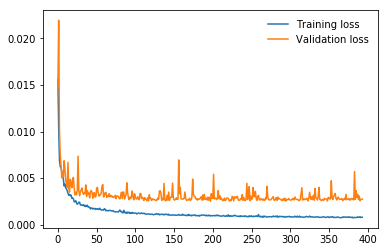

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(eval_losses, label='Validation loss')
plt.legend(frameon=False)


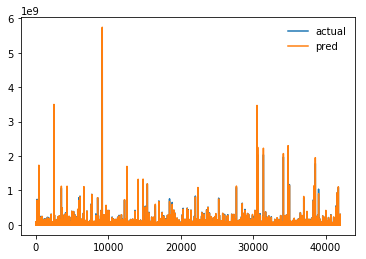

In [21]:
model.eval()
label = y_train.cpu()
label = y_scaler.inverse_transform(label)
with torch.no_grad():
    pred = model(X_train)
    pred = pred.cpu().numpy()
    pred = y_scaler.inverse_transform(pred)
    plot(label, pred)

## Submission 

In [22]:
pred = test_func(model, X_test)


In [23]:
submission = pd.read_csv('./dataset-0510/submit_test.csv')
submission['total_price'] = pred
submission.to_csv('submission/DNN2_result.csv', index=False)
submission

,building_id,total_price
0,X5gsdTWGS3W7JJQB,1.132997e+07
1,BTshNOJyKHnT2YIT,3.951944e+06
2,dhdymr0lV8N5kZOT,1.026775e+07
3,VEwyGGMcD56w5BOc,1.128428e+07
4,wmUeMoJZfsqaSX9b,1.960572e+06
5,EtBjGAHmHCe9t7TZ,1.960572e+06
6,hPNH34vmaZtvBtqc,1.395539e+07
7,wXjeI38bYDMJJwZC,1.176495e+07
8,fxZSGX6aPAFKU8W4,1.960572e+06
9,ewr0Fx6ign87OwaV,3.435798e+06


### test result

Batch size use 128 or 32 , learning rate use 0.003 which find loss will stock in 0.6

Result 1 DNN 233->256->128->1, lr=0.001, batch_size=128, predict score : 13
change: 
- replacing Standard to MinMax 
- adding DropOut 0.3 layer
- batch size change to 512

Result 2 lr=0.001, batch_size=64, DNN 233->256->128->64->1
after 1k loss : 0.00011785521522113447, can't decrease...
- x_scale false
- y_scale true

Result 3 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->1
after 1w loss : 0.0003, test loss : 0.0007 score: 1670

Result 4 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1
train_loss: 0.0004, test loss: 0.0002 score: 1600

Result 5 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram
train_loss: 0.0005, test loss: 0.003 score: 1000

Result 6 lr=0.001 batch_size=128 DNN 211->256->512->512->256->128->64->1 + batch_noram + weight_decay
after 2k
train_loss: 0.004, test loss 0.006 ,look like L2 regular not work which will increase loss

Result 6 lr=0.0015 batch_size=128 DNN 211->256->512->512->256->128->64->32->1 + batch_noram
after 3k
train_loss 0.0004 test loss 0.002 score : 1400
I think we should reduce lr or add L2 regularzation

### question

why output is negative?